In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR, Ridge
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [223]:
data = pd.read_csv('/home/denis/Загрузки/train.csv')
test = pd.read_csv('/home/denis/Загрузки/test.csv')

In [3]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 3.2 MB


Оптимизация занимаемой памяти.
Уменьшение объма выделенной памяти для числовых значений
Перевод строковых значений из типа objtct в cftegory(пока все поля переводятся, дальше надо смотреть)
оригинальная статья: https://habr.com/ru/company/ruvds/blog/442516/

In [4]:
def memory_optim(data):
    conv_int = data.select_dtypes('int64').apply(pd.to_numeric, downcast='unsigned')
    conv_float = data.select_dtypes('float').apply(pd.to_numeric, downcast='float')
    # data = data.copy()
    data[conv_int.columns] = conv_int
    data[conv_float.columns] = conv_float
#     data.loc[:, data.select_dtypes('object').columns] = \
#         data[data.select_dtypes('object').columns].astype('category')
    return data

In [5]:
data = memory_optim(data)
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null uint16
DistrictId       10000 non-null uint8
Rooms            10000 non-null float32
Square           10000 non-null float32
LifeSquare       7887 non-null float32
KitchenSquare    10000 non-null float32
Floor            10000 non-null uint8
HouseFloor       10000 non-null float32
HouseYear        10000 non-null uint32
Ecology_1        10000 non-null float32
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null uint8
Social_2         10000 non-null uint16
Social_3         10000 non-null uint8
Healthcare_1     5202 non-null float32
Helthcare_2      10000 non-null uint8
Shops_1          10000 non-null uint8
Shops_2          10000 non-null object
Price            10000 non-null float32
dtypes: float32(8), object(3), uint16(2), uint32(1), uint8(6)
memory usage: 2.3 MB


In [6]:
data.describe(include='all')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000,10000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9903,9725,NaN,NaN,NaN,NaN,NaN,NaN,9175,NaN
mean,8383.40770,50.400800,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,NaN,NaN,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,NaN,214139.218750
std,4859.01902,43.587592,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,NaN,NaN,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,NaN,92872.304688
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,NaN,NaN,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,NaN,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,NaN,NaN,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,NaN,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,NaN,NaN,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,NaN,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,NaN,NaN,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,NaN,249135.460938


In [132]:
# test_cov = data[['Social_1', 'Social_2', 'Social_3', 'Price']]

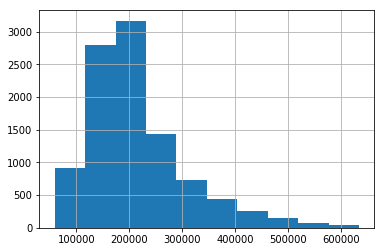

In [139]:
# test_cov['Price'].hist()

Обработка предположения, что была допущена ошибка при заполнении данных о годе

In [7]:
data.loc[(data['HouseYear'] > 2021)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.531250
4189,11607,147,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.609375


In [8]:
data = data.drop('Healthcare_1', axis=1)

In [9]:
data.loc[(data['HouseYear'] == 20052011), 'HouseYear'] = 2008

In [10]:
data.loc[(data['HouseYear'] == 4968), 'HouseYear'] = 1968

Исправлены даты

In [11]:
data.loc[(data['HouseYear'] < 2021)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,8.903972e-02,B,B,33,7976,5,0,11,B,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,6.998930e-05,B,B,46,10309,1,1,16,B,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,4.963726e-02,B,B,34,7759,0,1,3,B,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,4.378853e-01,B,B,23,5735,3,0,5,B,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,1.233889e-02,B,B,35,5776,1,2,4,B,150226.531250
5,12915,59,3.0,80.384476,46.683720,12.0,5,17.0,2011,3.094791e-01,B,B,35,7715,4,0,6,B,215898.453125
6,14549,154,2.0,62.254112,37.160378,7.0,3,5.0,1960,4.605564e-01,B,B,20,4386,14,1,5,B,296021.218750
7,11993,74,2.0,80.312927,NaN,0.0,14,0.0,1977,7.577875e-02,B,B,6,1437,3,0,2,B,221244.156250
8,5172,1,2.0,64.511436,NaN,1.0,9,17.0,1977,7.122317e-03,B,B,1,264,0,0,1,B,229102.796875
9,8649,23,1.0,46.461411,18.915552,8.0,13,17.0,2014,7.577875e-02,B,B,6,1437,3,0,2,B,95380.218750


Работа с площадью

In [12]:
data.loc[(data['Square'] < 15)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628716,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,3,9,B,412511.093750
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,0,0,B,107604.265625
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,0,0,B,137597.593750
3280,10527,27,1.0,4.380726,40.805836,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,0,1,B,97560.718750
3413,9487,5,1.0,5.129221,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,4,5,B,369472.406250
4739,12676,81,3.0,13.784864,15.988890,7.0,4,5.0,1960,0.319809,B,B,25,4756,16,5,8,B,78388.804688
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,0,0,B,126596.945312
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,0,1,B,161379.062500
6392,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,0,1,B,181434.828125
8030,13265,1,3.0,4.823679,79.767967,0.0,6,17.0,1977,0.007122,B,B,1,264,0,0,1,B,237716.687500


Решено удалить эти данные, с общей площадью меньше 15 м^2, так как их объем не значителен и приведение их площади к каким-либо стредним значениям на данный момент затруднителен. Остальные плошади (LifeSquare, KitchenSquare) вызывают сомнения.

In [13]:
def drop_little_square(data):
    index_array_square = data.loc[(data['Square'] < 15)].index
    data = data.drop(index_array_square, axis=0).reset_index(drop=True)
    return data

In [14]:
data = drop_little_square(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9987 entries, 0 to 9986
Data columns (total 19 columns):
Id               9987 non-null uint16
DistrictId       9987 non-null uint8
Rooms            9987 non-null float32
Square           9987 non-null float32
LifeSquare       7874 non-null float32
KitchenSquare    9987 non-null float32
Floor            9987 non-null uint8
HouseFloor       9987 non-null float32
HouseYear        9987 non-null int64
Ecology_1        9987 non-null float32
Ecology_2        9987 non-null object
Ecology_3        9987 non-null object
Social_1         9987 non-null uint8
Social_2         9987 non-null uint16
Social_3         9987 non-null uint8
Helthcare_2      9987 non-null uint8
Shops_1          9987 non-null uint8
Shops_2          9987 non-null object
Price            9987 non-null float32
dtypes: float32(7), int64(1), object(3), uint16(2), uint8(6)
memory usage: 682.8+ KB


Работа с жилой площадью

In [15]:
data.loc[(data['LifeSquare'] == 7480.592285)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
4323,16550,27,3.0,81.69442,7480.592285,1.0,9,17.0,2016,0.017647,B,B,2,469,0,0,0,B,217357.5


In [16]:
data.loc[(data['LifeSquare'] == 7480.592285), 'LifeSquare'] = 74.805922

In [17]:
data.loc[(data['LifeSquare'] == 74.805922)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
4323,16550,27,3.0,81.69442,74.805923,1.0,9,17.0,2016,0.017647,B,B,2,469,0,0,0,B,217357.5


Рассмотрим квартиры с жилой площадью меньше 1, так как там может быть явная ошибка

In [18]:
data.loc[(data['LifeSquare'] < 1), :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
26,4378,27,3.0,106.958870,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,0,0,A,337299.875000
6600,13491,0,1.0,38.178276,0.370619,0.0,19,17.0,2016,0.006076,B,B,30,5285,0,6,6,B,105134.289062
9590,5112,6,2.0,63.591740,0.795539,10.0,17,17.0,2014,0.243205,B,B,5,1564,0,0,0,B,174742.000000


Очевидно, что при внесении данных по квартире с Id 4378 и 13491 была допущена ошибка. При перепланировке была увеличена жилая площадь за счет кухни, следовательно она вполне могла сравняться по площади с площадью самой квартиры.  

In [19]:
data.loc[data['Id'] == 4378, 'LifeSquare'] = 106.41822
data.loc[data['Id'] == 13491, 'LifeSquare'] = 0.370619 * 100

Ситуация с квартирой Id 5112 не так очевидна. Проанализируем все квартиры с 2 комнатами и кухней 10 кв.м. Так же для уменьшения вариантов положим год постройки равным 2014

In [20]:
data.loc[(data['KitchenSquare'] == 10) & (data['Rooms'] == 2) & (data['HouseYear'] == 2014), :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
101,3973,1,2.0,62.969902,31.745611,10.0,14,14.0,2014,0.007122,B,B,1,264,0,0,1,B,92127.062500
2383,6444,93,2.0,63.333702,33.794670,10.0,4,16.0,2014,0.050900,B,B,43,10621,1,2,3,B,146350.796875
2731,11025,27,2.0,96.043564,100.982132,10.0,5,6.0,2014,0.075424,B,B,11,3097,0,0,0,B,126277.109375
3685,8440,120,2.0,65.470390,35.318195,10.0,20,22.0,2014,0.000699,B,B,14,3369,24,0,3,B,147964.468750
4475,16635,48,2.0,82.888695,81.127533,10.0,24,25.0,2014,0.041125,B,B,46,9515,5,1,10,B,428238.093750
6771,14760,27,2.0,64.125572,29.315821,10.0,12,1.0,2014,0.017647,B,B,2,469,0,0,0,B,155608.921875
7005,7145,27,2.0,57.835629,56.948929,10.0,4,12.0,2014,0.011654,B,B,4,915,0,0,0,B,143111.593750
7990,934,34,2.0,64.168762,NaN,10.0,14,25.0,2014,0.069753,B,B,53,13670,4,1,11,B,288510.031250
9386,4901,6,2.0,66.061874,43.373966,10.0,9,25.0,2014,0.243205,B,B,5,1564,0,0,0,B,185518.562500
9590,5112,6,2.0,63.591740,0.795539,10.0,17,17.0,2014,0.243205,B,B,5,1564,0,0,0,B,174742.000000


Исходя из полученных данных можно вычислить жилую площадь данной квартиры как среднюю долю от общей площади квартиры.  
Так же получили интересное наблюдение:  
Судя по всему при заполнении формы не было четко определено как учитывать метраж кухни - включая его в жилую площадь или нет, поэтому в некоторых случаях (Id 16635) метраж кухни очевидно включен в жилую площадь, а в некоторых - нет (Id 8440)  
Если подобных случаев достаточно много, то данное обстоятельство может серьезно исказить картину при анализе цены и необходимо исключить кухонные метры из жилой площади.  


In [21]:
data.query('Square - LifeSquare < KitchenSquare & KitchenSquare > 0')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,0,5,B,175616.234375
28,8054,23,1.0,42.530045,43.967758,1.0,3,9.0,2014,0.034656,B,B,0,168,0,0,0,B,95338.195312
48,7596,23,1.0,47.080101,46.807991,12.0,3,9.0,1977,0.014073,B,B,2,475,0,0,0,B,96029.164062
69,6925,27,2.0,64.929100,63.304604,10.0,15,17.0,2016,0.072158,B,B,2,629,1,0,0,A,228584.000000
123,8753,25,3.0,85.952309,89.803749,1.0,4,3.0,2017,0.069753,B,B,53,13670,4,1,11,B,309688.593750
129,6072,6,1.0,65.102020,64.622604,1.0,10,9.0,2015,0.243205,B,B,5,1564,0,0,0,B,175899.984375
136,6172,27,2.0,92.400009,92.069237,10.0,2,5.0,1977,0.075424,B,B,11,3097,0,0,0,B,116942.671875
145,14787,34,2.0,60.366627,57.709148,10.0,20,19.0,2017,0.069753,B,B,53,13670,4,1,11,B,241737.812500
147,3287,27,3.0,92.885544,91.642250,13.0,7,17.0,2015,0.072158,B,B,2,629,1,0,0,A,206780.546875
153,9870,62,1.0,51.831474,53.491302,1.0,5,1.0,2015,0.072158,B,B,2,629,1,0,0,A,131797.468750


Посмотрим наш датасет в разрезе общей площади и ее распределении.

In [22]:
data_squares = data[['Square', 'LifeSquare', 'KitchenSquare', 'Rooms', 'HouseYear']]
data_squares.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9987 entries, 0 to 9986
Data columns (total 5 columns):
Square           9987 non-null float32
LifeSquare       7874 non-null float32
KitchenSquare    9987 non-null float32
Rooms            9987 non-null float32
HouseYear        9987 non-null int64
dtypes: float32(4), int64(1)
memory usage: 234.1 KB


Поле LifeSquare имеет доволно большое количество пропусков. Их можно будет заполнить средними показателями доли жилой площади от общей.  
Однако, сначала необходимо скорректировать жилые площади, в которые включены площади кухонь. 

In [23]:
data_squares = data_squares.loc[data_squares['LifeSquare'].notna(), :]

In [24]:
data_squares.describe()

,Square,LifeSquare,KitchenSquare,Rooms,HouseYear
count,7874.000000,7874.000000,7874.000000,7874.000000,7874.000000
mean,55.318081,36.308105,7.593599,1.921133,1985.714503
std,20.331745,20.262745,32.028202,0.855803,19.582069
min,16.117155,0.795539,0.000000,0.000000,1910.000000
25%,41.197308,22.805752,5.000000,1.000000,1971.000000
50%,50.920542,32.790060,7.000000,2.000000,1979.000000
75%,64.739902,45.144626,9.000000,3.000000,2004.000000
max,641.065186,638.163208,2014.000000,19.000000,2020.000000


Кухонное пространство тоже заносилось не всегда корректно, попробуем с ним немного поработать

In [25]:
for i in range(5):
    print(f'Количество кухонь с площадью более {(i + 5) * 10}% от общей площади: '
          f'{len(data_squares[data_squares["KitchenSquare"] >= data_squares["Square"] * ((i + 5) / 10)])}')

Количество кухонь с площадью более 50% от общей площади: 30
Количество кухонь с площадью более 60% от общей площади: 30
Количество кухонь с площадью более 70% от общей площади: 30
Количество кухонь с площадью более 80% от общей площади: 30
Количество кухонь с площадью более 90% от общей площади: 28


In [26]:
data_squares[data_squares["KitchenSquare"] >= data_squares["Square"] * 0.5]

,Square,LifeSquare,KitchenSquare,Rooms,HouseYear
226,79.722244,44.731220,72.0,3.0,1987
550,48.128113,45.023533,48.0,1.0,2013
1063,47.100719,46.447960,2014.0,1.0,2014
1076,40.081043,37.834965,37.0,1.0,2019
1367,68.841072,64.234955,66.0,2.0,2014
1453,79.810532,79.578964,78.0,2.0,2014
1857,53.216778,32.644859,53.0,2.0,1994
2913,97.490677,99.323555,96.0,3.0,2019
2966,114.734474,112.589081,112.0,3.0,2015
3375,36.138409,36.710541,36.0,1.0,2017


In [27]:
data_squares.loc[(data_squares['LifeSquare'] > data_squares['Square'] * 0.9) &
                (data_squares['KitchenSquare'] >= data_squares['Square'] * 0.5)]

,Square,LifeSquare,KitchenSquare,Rooms,HouseYear
550,48.128113,45.023533,48.0,1.0,2013
1063,47.100719,46.447960,2014.0,1.0,2014
1076,40.081043,37.834965,37.0,1.0,2019
1367,68.841072,64.234955,66.0,2.0,2014
1453,79.810532,79.578964,78.0,2.0,2014
2913,97.490677,99.323555,96.0,3.0,2019
2966,114.734474,112.589081,112.0,3.0,2015
3375,36.138409,36.710541,36.0,1.0,2017
4105,66.787521,64.616661,60.0,2.0,2015
4137,42.357487,44.779713,41.0,1.0,2016


In [28]:
mean_life_to_total = data.loc[(data['KitchenSquare'] != 0) & (data['LifeSquare'].notna())]
np.mean(mean_life_to_total.LifeSquare / mean_life_to_total.Square)

0.6427067518234253

Квартиры, в которых жилая площадь примерно равна общей и количество комнат 0 или 1 - это современные постройки, таким образом скорее всего это квартиры-студии. В таких кухня отдельно не выделяется, значит приравняем ее к 0.

Оставшиеся кухни с площадью более половины общей площади квартиры разделим на 10, так как очень похоже на то, что призанесении данных пытались проставить дробное значение.

Средний показатель отношения жилой площади к общей составляет 64%. Предположим что если доля кухонного пространства превышает 20% от общего, да еще и остается на жилые и технические помещения менее 60% - то это тоже не нормальная ситуация и следует привести кухонные метры к 20% (на данном этапе сложно точнее определить долю кухонь, да это не требуется пока. Исходим из примерного распределения квартирного пространства как 65% / 25% / 15% - жилая площадь/кухня/технические помещения)

In [29]:
def optim_large_kitchen(data):
    data.loc[(data['LifeSquare'] > data['Square'] * 0.9) & \
             (data['KitchenSquare'] >= data['Square'] * 0.5) & \
             (data['Rooms'] <= 1), 'KitchenSquare'] = 0

    data.loc[(data['KitchenSquare'] > data['Square'] * 0.5), 'KitchenSquare'] = \
        np.round(data.loc[(data['KitchenSquare'] > data['Square'] * 0.5), 'KitchenSquare'] / 10)
    
    data.loc[(data['KitchenSquare'] > data['Square'] * 0.2) & \
         (data['Square'] - data['KitchenSquare'] <= data['Square'] * 0.6), 'KitchenSquare'] = \
    data.loc[(data['KitchenSquare'] > data['Square'] * 0.2) & \
         (data['Square'] - data['KitchenSquare'] <= data['Square'] * 0.6), 'Square'] * 0.2
    
    return data

In [30]:
data = optim_large_kitchen(data)
data_squares = optim_large_kitchen(data_squares)

In [31]:
data_squares.loc[(data_squares['KitchenSquare'] > data_squares['Square'] * 0.5)]

,Square,LifeSquare,KitchenSquare,Rooms,HouseYear


Осталось проанализировать кухни равные 0, не все такие квартиры - студии. Такие кваритиры появились недавно - будем считать, что студии - это постройки от 2005 года и позднее, имеющие площадь кухни равную 0 и количество комнат 0 или 1.  
Кухня в квартире Id 8573 будет так же расчитана как доля от среденго.

In [32]:
data_squares.query('KitchenSquare == 0 & HouseYear < 2005').describe()

,Square,LifeSquare,KitchenSquare,Rooms,HouseYear
count,127.000000,127.000000,127.0,127.000000,127.000000
mean,60.837708,54.291084,0.0,1.858268,1976.496063
std,21.161930,25.397562,0.0,0.773822,3.951841
min,16.117155,1.819834,0.0,0.000000,1955.000000
25%,43.178190,38.305960,0.0,1.000000,1977.000000
50%,62.465862,55.028625,0.0,2.000000,1977.000000
75%,73.840153,69.376770,0.0,2.000000,1977.000000
max,162.587891,164.526764,0.0,3.000000,2003.000000


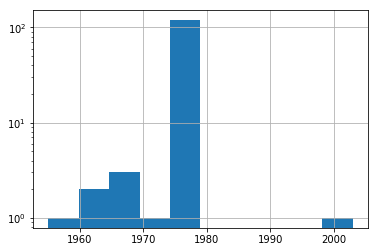

In [33]:
data_squares.query('KitchenSquare == 0 & HouseYear < 2005')['HouseYear'].hist(log=True)

In [34]:
data_squares.query('KitchenSquare == 0 & HouseYear < 2005')['HouseYear'].value_counts()

1977    118
2003      1
1975      1
1974      1
1968      1
1966      1
1965      1
1962      1
1961      1
1955      1
Name: HouseYear, dtype: int64

Получили интересное наблюдение - все квартиры, удовлетворяющие условиям студий старше 2005 года, однако есть квартиры старше. Из них особенно выделяются квартиры 1977 года, в которых площадь равна жилой площади и кухня равна 0.  
Это может быть связано с недобросовестностью оператора (сейчас или ранее), либо говорит о том, что по этому году нет статистики по кухням и реестры заполнялись подобным образом.  
Рассмотрим все постройки 1977 года и примем решение - исключить их или попробовать привести к средним значениям (для  упрщения квартиры не 1977 года будем считать по правилам 1977).

In [35]:
data_squares.loc[(data_squares['HouseYear'] == 1977)].describe()

,Square,LifeSquare,KitchenSquare,Rooms,HouseYear
count,786.000000,786.000000,786.000000,786.000000,786.0
mean,58.613255,44.112740,3.749943,1.821883,1977.0
std,18.798904,25.959177,4.308477,0.797343,0.0
min,27.264870,1.104689,0.000000,0.000000,1977.0
25%,43.529703,27.579919,1.000000,1.000000,1977.0
50%,56.655886,42.280540,1.000000,2.000000,1977.0
75%,66.840118,60.817431,7.000000,2.000000,1977.0
max,163.495331,164.526764,43.000000,5.000000,1977.0


Анализ показал, что есть кухни с метражем 1. Так как по ГОСТу кухни не делали меньше 4 метров, то имеет смысл усреднить все аномально маленькие кухни. Посмотрим статистику.

In [36]:
data_squares.loc[(data_squares['HouseYear'] < 2005) & (data_squares['KitchenSquare'] <= 3)].info()
# / data_squares.loc[(data_squares['HouseYear'] == 1977) & (data_squares['KitchenSquare'] > 1)].count()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531 entries, 2 to 9925
Data columns (total 5 columns):
Square           531 non-null float32
LifeSquare       531 non-null float32
KitchenSquare    531 non-null float32
Rooms            531 non-null float32
HouseYear        531 non-null int64
dtypes: float32(4), int64(1)
memory usage: 16.6 KB


In [37]:
# data_squares.loc[(data_squares['HouseYear'] < 2005) & (data_squares['KitchenSquare'] > 3)].describe()
data_squares.loc[(data_squares['KitchenSquare'] > 3)].describe()

,Square,LifeSquare,KitchenSquare,Rooms,HouseYear
count,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000
mean,54.527058,34.308022,7.964363,1.950704,1983.416392
std,20.138988,17.804724,2.579758,0.863259,18.613365
min,16.547241,0.795539,3.309448,0.000000,1910.000000
25%,40.818172,22.660515,6.000000,1.000000,1969.000000
50%,49.516108,31.758046,8.000000,2.000000,1979.000000
75%,63.441777,42.387718,10.000000,3.000000,1999.750000
max,641.065186,638.163208,43.000000,19.000000,2020.000000


Данных достаточно для вычисления доли кухни от общей площади и усреднения.  
 - усредним маленькие кухни до 2005 года  
 - усредним маленькие кухни после 2005 года, исключая квартиры-студии
 - усредним оставшиеся выбросы по кухням, ткие как квартира с Id 8573 и метражем кухни 197 метров
 - доведем кухни оставшиеся маленькие кухни до ГОСТа - 4 метра

In [38]:
def optim_small_kitchen(data, source_data):
    kitchen_rate = np.mean(source_data.loc[(source_data['KitchenSquare'] > 3), 'KitchenSquare']
                          / source_data.loc[(source_data['KitchenSquare'] > 3), 'Square'])
    
    data.loc[(data['HouseYear'] < 2005) & (data['KitchenSquare'] <= 3), 'KitchenSquare'] = \
    np.round(data.loc[(data['HouseYear'] < 2005) & (data['KitchenSquare'] <= 3), 'Square'] * kitchen_rate)

    data.loc[(data['KitchenSquare'] != 0) & (data['KitchenSquare'] <= 3), 'KitchenSquare'] = \
    np.round(data.loc[(data['KitchenSquare'] != 0) & (data['KitchenSquare'] <= 3), 'Square'] * kitchen_rate)
    
    data.loc[(data['KitchenSquare'] == 0) & (data['Rooms'] > 1) & \
             (data['KitchenSquare'] <= 3), 'KitchenSquare'] = \
    np.round(data.loc[(data['KitchenSquare'] == 0) & (data['Rooms'] > 1) & \
                      (data['KitchenSquare'] <= 3), 'Square'] * kitchen_rate)
    
    data.loc[(data['KitchenSquare'] > data['Square'] * 0.5), 'KitchenSquare'] = \
    np.round(data.loc[(data['KitchenSquare'] > data['Square'] * 0.5), 'Square'] * kitchen_rate)
    
    data.loc[(data['KitchenSquare'] > 0) & (data['KitchenSquare'] < 4), 'KitchenSquare'] = 4
    
    return data

In [39]:
data = optim_small_kitchen(data, data)
data_squares = optim_small_kitchen(data_squares, data_squares)

In [40]:
data_squares.loc[(data_squares['KitchenSquare'] != 0)].describe()

,Square,LifeSquare,KitchenSquare,Rooms,HouseYear
count,7831.000000,7831.000000,7831.000000,7831.000000,7831.000000
mean,55.348564,36.270699,8.150995,1.926446,1985.548461
std,20.257372,20.159344,2.702937,0.854979,19.505978
min,16.117155,0.795539,4.000000,0.000000,1910.000000
25%,41.216724,22.797475,6.000000,1.000000,1971.000000
50%,51.057800,32.765469,8.000000,2.000000,1979.000000
75%,64.810596,45.128803,10.000000,3.000000,2004.000000
max,641.065186,638.163208,43.000000,19.000000,2020.000000


Обратим внимание на студии. Есть такие, у которых жилая площадь превышает общую. Скорее всего это превышение ни что иное как разного рода технические помещения - их надо учесть в общей площади, соответственно сократив жилую

In [41]:
data_squares.loc[(data_squares['KitchenSquare'] == 0) & 
                  (data_squares['LifeSquare'] < data_squares['Square'] * 0.9)]

,Square,LifeSquare,KitchenSquare,Rooms,HouseYear
338,50.390862,41.642899,0.0,1.0,2008
3042,40.288834,1.487210,0.0,1.0,2016
4751,40.490421,4.114601,0.0,1.0,2019
5048,38.936985,3.064320,0.0,1.0,2017
6153,51.018288,22.370991,0.0,1.0,2016
6229,45.036224,40.481152,0.0,1.0,2014
6746,86.386757,71.904999,0.0,1.0,2012
7047,41.941914,4.437475,0.0,1.0,2016
7873,41.038761,36.049416,0.0,1.0,2014
8704,53.835575,1.185864,0.0,1.0,2018


Выше приведены очевидные квартиры-студии с не верно заполненной жилой площадью.  
Выведем средний коэффициент технических помещений в подобных квартирах и приведем их жилую площадь к средней

In [42]:
def get_overcount(df, query, columns):
    part_more_total = df.query(query)[columns]
    part_more_total['Overcount'] = np.abs(part_more_total[columns[0]] - part_more_total[columns[1]])
    part_more_total[f'{columns[1]}_r'] = part_more_total[columns[0]] - part_more_total['Overcount']
    return part_more_total    

In [43]:
def optim_stud_lifesquare(data, source_data):
    data_squares_stud_source = get_overcount(source_data, 'KitchenSquare == 0 & LifeSquare > Square', 
                                 ['Square', 'LifeSquare'])
    
    data_squares_stud = get_overcount(data, 'KitchenSquare == 0 & LifeSquare > Square', 
                                 ['Square', 'LifeSquare'])

    data.loc[data_squares_stud.index, 'LifeSquare'] = data_squares_stud['LifeSquare_r']
    
    tech_mean = np.mean(data_squares_stud_source['Overcount'] / data_squares_stud_source['Square'])
    
    print(tech_mean)
    
    data.loc[(data['KitchenSquare'] == 0) & 
                  ((data['LifeSquare'] < data['Square'] * 0.9) | 
                  (data['LifeSquare'].isna())), 'LifeSquare'] = \
    data.loc[(data['KitchenSquare'] == 0) & 
                  ((data['LifeSquare'] < data['Square'] * 0.9) |
                  (data['LifeSquare'].isna())), 'Square'] * (1 - tech_mean)
    
    return data

In [44]:
data = optim_stud_lifesquare(data, data)
data_squares = optim_stud_lifesquare(data_squares, data_squares)

0.04136935621500015
0.04136935621500015


In [45]:
data.loc[(data['KitchenSquare'] == 0), ['Square', 'LifeSquare', 'KitchenSquare', 'HouseYear']].describe()

,Square,LifeSquare,KitchenSquare,HouseYear
count,47.000000,47.000000,47.0,47.000000
mean,49.477486,47.650898,0.0,2015.914894
std,29.683886,29.567192,0.0,2.320324
min,27.778509,26.438013,0.0,2008.000000
25%,38.960737,37.580576,0.0,2015.000000
50%,43.990707,41.844398,0.0,2016.000000
75%,49.937181,47.871311,0.0,2017.000000
max,212.932358,211.231125,0.0,2019.000000


Аналогичная ситуация может быть и с обычными квартирами.

In [46]:
life_more_total = get_overcount(data, 'LifeSquare > Square', ['Square', 'LifeSquare', 'KitchenSquare'])
life_more_total.describe()

,Square,LifeSquare,KitchenSquare,Overcount,LifeSquare_r
count,460.000000,460.000000,460.000000,460.000000,460.000000
mean,60.358948,63.565544,9.226087,3.206559,57.152412
std,28.506554,35.586384,3.227905,21.261316,35.537918
min,16.547241,16.698570,4.000000,0.013302,-305.344971
25%,41.028492,42.455050,6.750000,0.669343,39.919859
50%,54.869051,56.928204,9.000000,1.462597,53.414427
75%,72.358570,74.803307,10.000000,2.395637,70.500677
max,409.425171,461.463623,26.000000,383.404297,408.210602


438 квартир имеют аномальную жилую площадь. Так же наблюдаются выбросы. Предположим, что под разного рода технические помещения выделяется не более 4 метров (среднее значение 3,21)

In [47]:
life_more_total.query('Overcount > 4').assign(over_to_total = life_more_total.query('Overcount > 4')['Overcount']
                                / life_more_total.query('Overcount > 4')['Square'])

,Square,LifeSquare,KitchenSquare,Overcount,LifeSquare_r,over_to_total
589,48.449875,263.542023,5.0,215.092148,-166.642273,4.439478
1312,42.357697,46.520149,5.0,4.162453,38.195244,0.098269
1507,52.534283,56.961781,8.0,4.427498,48.106785,0.084278
1990,64.061829,68.788239,10.0,4.726410,59.335419,0.073779
2003,37.759975,41.847858,6.0,4.087883,33.672092,0.108260
2296,84.486076,88.931511,13.0,4.445435,80.040642,0.052617
2731,96.043564,100.982132,10.0,4.938568,91.104996,0.051420
2751,58.744030,62.923073,9.0,4.179043,54.564987,0.071140
4204,38.049225,42.672680,10.0,4.623455,33.425770,0.121512
4272,79.130547,83.470009,12.0,4.339462,74.791084,0.054839


In [48]:
data.query('abs(Square - LifeSquare) < 1').assign(tech_zone = data.Square - data.LifeSquare)[ \
                    ['Square', 'LifeSquare', 'KitchenSquare', 'tech_zone']].describe()

,Square,LifeSquare,KitchenSquare,tech_zone
count,386.000000,386.000000,386.000000,386.000000
mean,58.418171,58.341690,9.095855,0.076496
std,20.804918,20.801865,3.575329,0.555231
min,16.547241,16.698570,0.000000,-0.998451
25%,41.542551,41.570376,7.000000,-0.332156
50%,54.844006,54.753130,9.500000,0.125973
75%,68.900705,68.764204,10.000000,0.515219
max,174.649521,174.837082,43.000000,0.997910


Очевидно, что данные с Id 589, 6324, 8426, это ошибка оператора. Так же по данным видно, что подобные технические помещения в среднем не превышают 15% от общей площади квартиры, следвательно сократим жилую площадь на 15% от общей.  
Точно так же поступим с квартирами, в которых технические помещения меньше 1 метра (в квартире должен быть как минимум туалет).  
Остальные значения удовлетворяют здравому смыслу и могут быть техническими помешениями.


Проверим: есть ли квартиры, у которых кухня включена в жилую площадь (как упоминалось ранее такого быть не должно). Соответственно, если разница между общей площадью и жилой меньше площади кухни, то допущена ошибка и мы уменьшим жилую площадь на площадь кухни.

In [49]:
data_squares.loc[(data_squares['Square'] - data_squares['LifeSquare'] < data_squares['KitchenSquare'])].describe()

,Square,LifeSquare,KitchenSquare,Rooms,HouseYear
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,61.129032,60.911514,9.421046,1.806723,1999.430252
std,28.942181,31.801363,3.086081,0.808671,19.728598
min,16.547241,15.170851,4.000000,0.000000,1918.000000
25%,43.087450,42.309091,7.000000,1.000000,1977.000000
50%,57.584473,56.849438,10.000000,2.000000,2014.000000
75%,72.146372,70.849602,11.000000,2.000000,2016.000000
max,641.065186,638.163208,43.000000,5.000000,2020.000000


Ранее мы предположили, что площадь квартиры не может быть меньше 15 кв.м. Следовательно логично предположить, что жилая площадь не может быть меньше, чем 15 * среднюю долю жилого пространства (data_lifesquare_to_square_mean)

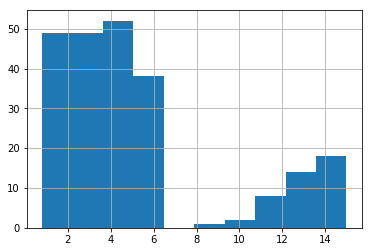

In [50]:
data_squares.query('LifeSquare < 15').LifeSquare.hist()

In [51]:
life_to_square = data.loc[(data['KitchenSquare'] != 0)].copy()
life_to_square['life_part'] = life_to_square['LifeSquare'] / life_to_square['Square']
life_to_square[['Square', 'LifeSquare', 'KitchenSquare', 'HouseYear', 'life_part']].describe()

,Square,LifeSquare,KitchenSquare,HouseYear,life_part
count,9940.000000,7831.000000,9940.000000,9940.000000,7831.000000
mean,56.415863,36.270699,8.411311,1984.719920,0.647946
std,20.935875,20.159344,2.932734,18.331873,0.205033
min,16.117155,0.795539,4.000000,1910.000000,0.012510
25%,41.804026,22.797474,6.000000,1974.000000,0.555977
50%,52.648144,32.765469,8.000000,1977.000000,0.617012
75%,65.953604,45.128803,10.000000,2000.250000,0.694410
max,641.065186,638.163208,93.000000,2020.000000,5.911703


In [52]:
life_to_square.loc[(life_to_square['LifeSquare'] < 15 * 0.647946), \
                  ['Square', 'LifeSquare', 'KitchenSquare', 'HouseYear', 'life_part']]

,Square,LifeSquare,KitchenSquare,HouseYear,life_part
95,61.334969,4.091945,9.0,2014,0.066715
134,65.496674,5.589324,10.0,1977,0.085338
158,51.991066,4.896202,8.0,1977,0.094174
160,66.419838,3.987101,10.0,1977,0.060029
269,46.692974,5.941401,7.0,2015,0.127244
278,79.521217,4.634048,12.0,2017,0.058274
362,44.171791,1.251846,7.0,2017,0.028340
474,64.049698,4.008230,10.0,2017,0.062580
476,63.419552,2.286357,10.0,1977,0.036051
526,53.733677,4.323046,8.0,2015,0.080453


In [53]:
np.mean(life_to_square.loc[(life_to_square['LifeSquare'] < 15 * 0.647946), 'LifeSquare'] * \
10 / life_to_square.loc[(life_to_square['LifeSquare'] < 15 * 0.647946), 'Square'])

0.6526333689689636

Исходя из полученных данных, получается:  
 - средняя жилая площадь около 65%  
 - для квартир с жилой площадью, меньше предположенной минимальной (15 * 65%), скорее всего была допущена ошибка при занесении данных. А именно - ошибочно поставленна точка. Таким образом, при умножении на 10 мы получили значеня близкие к среднему - 66% от общей площади  

Принимаем решение сделать жилую площадь таких квартир равную 65% от общей (так как ранее приняли нормальными соотношения площадей 65% / 25% / 15%)

In [54]:
def optim_lifesquare(data):
    data.loc[(data['LifeSquare'] - data['Square'] > data['Square'] * 0.15), 'LifeSquare'] = \
            data.loc[(data['LifeSquare'] - data['Square'] > data['Square'] * 0.15), 'Square'] * (1 - 0.15)
    
    life_more_total = get_overcount(data, 'LifeSquare > Square', ['Square', 'LifeSquare', 'KitchenSquare'])
    data.loc[life_more_total.index, 'LifeSquare'] = life_more_total['LifeSquare_r']
    
    data.loc[(data['Square'] - data['LifeSquare'] < 1), 'LifeSquare'] = \
        data.loc[(data['Square'] - data['LifeSquare'] < 1), 'Square'] * (1 - 0.15)
    
    data.loc[(data['Square'] - data['LifeSquare'] < data['KitchenSquare']), 
                'LifeSquare'] = \
        data.query('Square - LifeSquare < KitchenSquare')['LifeSquare'] - \
        data.query('Square - LifeSquare < KitchenSquare')['KitchenSquare']
    
    data.loc[(data['KitchenSquare'] != 0) & (data['LifeSquare'] < 15 * 0.647946), 'LifeSquare'] = \
        data.loc[(data['KitchenSquare'] != 0) & (data['LifeSquare'] < 15 * 0.647946), 'Square'] * 0.65
    
    return data

In [55]:
data.loc[(data['LifeSquare'] - data['Square'] > data['Square'] * 0.15)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
589,14990,23,2.0,48.449875,263.542023,5.0,6,5.0,1972,0.075779,B,B,6,1437,3,0,2,B,141780.234375
3163,15127,150,1.0,17.046188,20.036232,4.0,7,12.0,1982,0.300323,B,B,52,10311,6,1,9,B,74222.109375
6324,8961,27,1.0,33.398983,164.153366,6.0,3,5.0,1965,0.211401,B,B,9,1892,0,0,1,B,104891.070312
8426,15886,85,3.0,78.059334,461.463623,10.0,12,16.0,1998,0.037178,B,B,52,11217,1,1,7,B,394253.312500


In [56]:
data.query('LifeSquare > Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,42.530045,43.967758,7.0,3,9.0,2014,0.034656,B,B,0,168,0,0,0,B,95338.195312
44,10521,38,3.0,104.211395,106.340401,16.0,20,0.0,2017,0.060753,B,B,15,2787,2,0,7,B,435462.062500
52,2301,1,2.0,61.400055,65.224602,9.0,17,22.0,2016,0.007122,B,B,1,264,0,0,1,B,199215.453125
123,8753,25,3.0,85.952309,89.803749,13.0,4,3.0,2017,0.069753,B,B,53,13670,4,1,11,B,309688.593750
153,9870,62,1.0,51.831474,53.491302,8.0,5,1.0,2015,0.072158,B,B,2,629,1,0,0,A,131797.468750
178,2416,57,1.0,29.298168,29.770784,5.0,7,5.0,1964,0.133215,B,B,49,11395,3,3,4,A,148991.265625
184,3398,74,1.0,48.743664,51.011230,8.0,12,20.0,2017,0.075779,B,B,6,1437,3,0,2,B,165071.828125
216,5540,27,3.0,57.643612,59.425079,9.0,16,10.0,1977,0.072158,B,B,2,629,1,0,0,A,198351.890625
233,12633,27,3.0,81.867165,81.884544,13.0,12,19.0,1977,0.211401,B,B,9,1892,0,0,1,B,182228.515625
235,3916,1,1.0,43.084412,47.071617,7.0,9,7.0,2017,0.007122,B,B,1,264,0,0,1,B,169749.171875


In [57]:
data.loc[[28, 123, 153, 178, 184, 216]]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,42.530045,43.967758,7.0,3,9.0,2014,0.034656,B,B,0,168,0,0,0,B,95338.195312
123,8753,25,3.0,85.952309,89.803749,13.0,4,3.0,2017,0.069753,B,B,53,13670,4,1,11,B,309688.593750
153,9870,62,1.0,51.831474,53.491302,8.0,5,1.0,2015,0.072158,B,B,2,629,1,0,0,A,131797.468750
178,2416,57,1.0,29.298168,29.770784,5.0,7,5.0,1964,0.133215,B,B,49,11395,3,3,4,A,148991.265625
184,3398,74,1.0,48.743664,51.011230,8.0,12,20.0,2017,0.075779,B,B,6,1437,3,0,2,B,165071.828125
216,5540,27,3.0,57.643612,59.425079,9.0,16,10.0,1977,0.072158,B,B,2,629,1,0,0,A,198351.890625


In [58]:
data = optim_lifesquare(data)
data_squares = optim_lifesquare(data_squares)

In [59]:
data.loc[[589, 3163, 6324, 8426]]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
589,14990,23,2.0,48.449875,41.182396,5.0,6,5.0,1972,0.075779,B,B,6,1437,3,0,2,B,141780.234375
3163,15127,150,1.0,17.046188,10.489261,4.0,7,12.0,1982,0.300323,B,B,52,10311,6,1,9,B,74222.109375
6324,8961,27,1.0,33.398983,22.389137,6.0,3,5.0,1965,0.211401,B,B,9,1892,0,0,1,B,104891.070312
8426,15886,85,3.0,78.059334,66.350433,10.0,12,16.0,1998,0.037178,B,B,52,11217,1,1,7,B,394253.312500


In [60]:
data.loc[data['KitchenSquare'] != 0].describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
count,9940.000000,9940.000000,9940.000000,9940.000000,7831.000000,9940.000000,9940.000000,9940.000000,9940.000000,9940.000000,9940.00000,9940.00000,9940.000000,9940.000000,9940.000000,9940.000000
mean,8384.048390,50.477767,1.895573,56.415863,35.131409,8.411311,8.513883,12.616901,1984.719920,0.118934,24.75996,5367.51841,8.075755,1.323541,4.242052,214450.484375
std,4859.485028,43.647978,0.838481,20.935875,16.343443,2.932734,5.216541,6.759128,18.331873,0.119161,17.52249,4005.57619,23.896754,1.493100,4.811191,92753.093750
min,0.000000,0.000000,0.000000,16.117155,10.065155,4.000000,1.000000,0.000000,1910.000000,0.000000,0.00000,168.00000,0.000000,0.000000,0.000000,59174.777344
25%,4169.500000,20.000000,1.000000,41.804026,23.281540,6.000000,4.000000,9.000000,1974.000000,0.017647,6.00000,1564.00000,0.000000,0.000000,1.000000,154250.425781
50%,8396.500000,36.000000,2.000000,52.648144,32.432705,8.000000,7.000000,13.000000,1977.000000,0.075424,25.00000,5285.00000,2.000000,1.000000,3.000000,192564.343750
75%,12592.500000,75.000000,2.000000,65.953604,43.972466,10.000000,12.000000,17.000000,2000.250000,0.195781,36.00000,7242.00000,5.000000,2.000000,6.000000,249543.050781
max,16798.000000,209.000000,19.000000,641.065186,628.163208,93.000000,42.000000,117.000000,2020.000000,0.521867,74.00000,19083.00000,141.000000,6.000000,23.000000,633233.437500


Теперь наш датасет в разрезе соотношений площадей приведен к логичному виду без явных аномалий.  
Остались квартиры с не заполненной жилой площадью. Их логично будет заполнить средними или медианными значениями.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4f91db278>]],
      dtype=object)

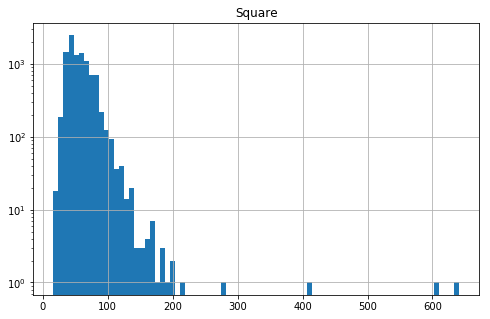

In [61]:
data[['Square']].hist(bins=80, log=True, figsize=(8, 5))

Однако прежде чем приступить к заполнению значений жилых помещений следует придумать что делать с явными выбросами в значениях общей площади. Как видно из гистограммы выше - есть 4 выброса.

In [62]:
data.query('Square > 250')[['Square', 'LifeSquare', 'KitchenSquare', 'Rooms', 'HouseYear', 'Price']]

,Square,LifeSquare,KitchenSquare,Rooms,HouseYear,Price
1979,275.645294,233.949310,26.0,5.0,2011,455264.875000
4257,604.705994,NaN,93.0,2.0,1977,187717.250000
4685,409.425171,398.210602,10.0,1.0,2016,90470.429688
6968,641.065186,628.163208,10.0,2.0,2019,133529.687500


И если квартира с id 1979 смотрится логично, то остальные - это явные выбросы.  
Если не брать в расчет цену квартиры, то можно попробовать оттолкнуться от количества комнат.

Посмотрим на них.

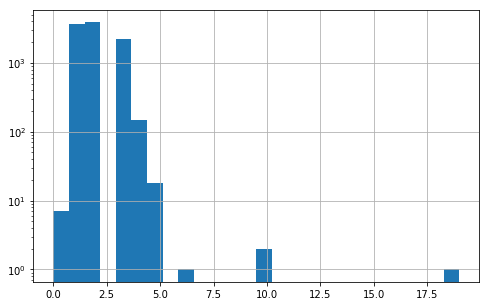

In [63]:
data['Rooms'].hist(bins=26, log=True, figsize=(8, 5))

In [64]:
data.loc[(data['Rooms'] > 5) | (data['Rooms'] == 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
376,5927,57,10.0,59.056976,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,5,15,B,317265.312500
1395,12638,27,0.0,138.427689,136.215500,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,0,0,B,268394.750000
1452,8491,1,19.0,42.006046,21.779287,7.0,17,17.0,2014,0.007122,B,B,1,264,0,0,1,B,78364.617188
1978,7917,27,0.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,0,1,B,302211.250000
2167,14003,99,6.0,59.414333,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,3,8,B,229661.968750
2266,7317,27,0.0,41.790882,NaN,6.0,13,0.0,1977,0.211401,B,B,9,1892,0,0,1,B,98129.976562
3906,770,28,0.0,49.483501,47.436401,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1,0,B,217009.343750
4361,456,6,0.0,81.491447,NaN,13.0,4,0.0,1977,0.243205,B,B,5,1564,0,0,0,B,212864.796875
6141,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,3,9,B,158998.109375
8823,9443,27,0.0,87.762619,71.125473,14.0,5,15.0,1977,0.211401,B,B,9,1892,0,0,1,B,219281.921875


In [65]:
data.loc[(data['KitchenSquare'] == 0) & (data['Rooms'] == 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
1395,12638,27,0.0,138.427689,136.215500,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,0,0,B,268394.75000
1978,7917,27,0.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,0,1,B,302211.25000
3906,770,28,0.0,49.483501,47.436401,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1,0,B,217009.34375


Количество комнат более 5, судя по площадям - это тоже ошибки заполнения. Так же есть квартиры с 0 комнат, часть из них - студии.  
Комнаты в студиях приравняем к 1.  
Остальные будем рассчитывать исходя из медианного значения жилой площади на 1 комнату.

In [66]:
norm_rooms = data.loc[(data['KitchenSquare'] != 0) & (
    data['Rooms'].between(1, 5)) & (data['LifeSquare'].notna())]. \
    assign(life_by_room = data['LifeSquare'] / data['Rooms']).copy()

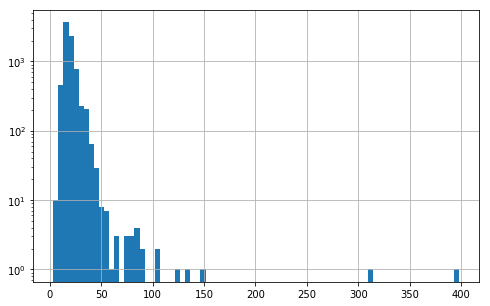

In [67]:
norm_rooms['life_by_room'].hist(bins=80, log=True, figsize=(8, 5))

In [68]:
norm_rooms.query('life_by_room > 50')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,life_by_room
341,7815,6,1.0,74.609612,59.685928,11.0,16,1.0,1977,0.243205,B,B,5,1564,0,0,0,B,216181.640625,59.685928
505,9552,23,1.0,105.432182,73.617355,16.0,3,2.0,1977,0.014073,B,B,2,475,0,0,0,B,218718.046875,73.617355
602,2070,30,1.0,70.868004,55.380035,11.0,14,14.0,2015,0.000078,B,B,22,6398,141,3,23,B,111851.445312,55.380035
609,9275,113,1.0,101.737701,74.881317,16.0,23,24.0,2019,0.050756,B,B,24,5469,1,0,1,B,396825.937500,74.881317
1638,11055,151,1.0,174.649521,148.452103,15.0,10,12.0,1958,0.236108,B,B,16,3893,27,3,10,B,232766.187500,148.452103
1915,13603,63,1.0,127.651237,82.973305,20.0,8,17.0,2016,0.238617,B,B,26,3889,6,3,6,B,594565.312500,82.973305
1953,15157,54,1.0,106.239624,83.296165,17.0,26,37.0,2009,0.006076,B,B,30,5285,0,6,6,B,274139.062500,83.296165
2685,3229,38,1.0,86.988869,73.940544,13.0,8,1.0,1977,0.060753,B,B,15,2787,2,0,7,B,374010.281250,73.940544
2949,15229,6,1.0,62.007599,50.925060,10.0,3,1.0,1977,0.243205,B,B,5,1564,0,0,0,B,195493.296875,50.925060
3057,3911,38,1.0,98.412643,82.201088,15.0,7,1.0,1977,0.060753,B,B,15,2787,2,0,7,B,434949.406250,82.201088


Медианное значение будет браться на датасете исключая:
 - квартиры-студии
 - квартиры с 0 комнат и более 5
 - квартиры с не заполненной жилой площадью
 - квартиры с площадью на 1 комнату более 50 метров

In [69]:
def optim_rooms(data, source_data):
    life_by_room = np.median(source_data.loc[(source_data['KitchenSquare'] != 0) & \
        (source_data['Rooms'].between(1, 5)) & (source_data['LifeSquare'].notna()) & \
        (source_data['LifeSquare'] / source_data['Rooms'] <= 50)]. \
        assign(life_by_room = source_data['LifeSquare'] / source_data['Rooms'])['life_by_room'])
    
    data.loc[(data['KitchenSquare'] == 0) & (data['Rooms'] == 0), 'Rooms'] = 1 
    
    data.loc[(data['Rooms'] > 5) | (data['Rooms'] == 0), 'Rooms'] = \
    data.loc[(data['Rooms'] > 5) | (data['Rooms'] == 0), 'Square'] * 0.65 // life_by_room
    
    return data

In [70]:
data = optim_rooms(data, data)

Теперь можно заменить пропущенные значения жилой пощади на средние значения по датасету (замена через количество комнат приводит к идентичному результату).

In [71]:
na_index = data.loc[(data['LifeSquare'].isna())].index

In [72]:
def fill_na_life(data, source_data):
    life_by_square = np.mean(source_data.loc[(source_data['LifeSquare'].notna()) & \
                                             (source_data['KitchenSquare'] != 0)]. \
        assign(life_by_square = source_data['LifeSquare'] / source_data['Square'])['life_by_square'])

    data['LifeSquare'] = data['LifeSquare'].fillna(data['Square'] * life_by_square)
                             
    return data

In [73]:
data = fill_na_life(data, data)

In [74]:
data.loc[na_index]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312927,50.403233,12.0,14,0.0,1977,0.075779,B,B,6,1437,3,0,2,B,221244.156250
8,5172,1,2.0,64.511436,40.486443,10.0,9,17.0,1977,0.007122,B,B,1,264,0,0,1,B,229102.796875
21,11935,27,2.0,64.711838,40.612213,10.0,15,1.0,1977,0.211401,B,B,9,1892,0,0,1,B,127200.023438
23,6641,54,3.0,118.907608,74.624695,18.0,2,0.0,1977,0.006076,B,B,30,5285,0,6,6,B,571069.062500
25,5073,74,2.0,82.667915,51.881187,13.0,16,17.0,1977,0.075779,B,B,6,1437,3,0,2,B,244145.828125
27,7550,23,2.0,64.556206,40.514542,10.0,8,17.0,1977,0.075779,B,B,6,1437,3,0,2,B,173910.921875
36,11703,23,1.0,41.118767,25.805544,6.0,4,17.0,1977,0.075779,B,B,6,1437,3,0,2,B,103510.226562
39,9371,23,2.0,60.503250,37.970963,9.0,16,0.0,1977,0.034656,B,B,0,168,0,0,0,B,229778.062500
43,175,23,2.0,58.692131,36.834332,9.0,16,17.0,1977,0.075779,B,B,6,1437,3,0,2,B,184501.015625
46,1821,23,2.0,49.929489,31.335026,8.0,9,12.0,1977,0.034656,B,B,0,168,0,0,0,B,88464.421875


In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9987 entries, 0 to 9986
Data columns (total 19 columns):
Id               9987 non-null uint16
DistrictId       9987 non-null uint8
Rooms            9987 non-null float32
Square           9987 non-null float32
LifeSquare       9987 non-null float32
KitchenSquare    9987 non-null float32
Floor            9987 non-null uint8
HouseFloor       9987 non-null float32
HouseYear        9987 non-null int64
Ecology_1        9987 non-null float32
Ecology_2        9987 non-null object
Ecology_3        9987 non-null object
Social_1         9987 non-null uint8
Social_2         9987 non-null uint16
Social_3         9987 non-null uint8
Helthcare_2      9987 non-null uint8
Shops_1          9987 non-null uint8
Shops_2          9987 non-null object
Price            9987 non-null float32
dtypes: float32(7), int64(1), object(3), uint16(2), uint8(6)
memory usage: 682.8+ KB


In [76]:
data.loc[(data['KitchenSquare'] != 0)].describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
count,9940.000000,9940.000000,9940.000000,9940.000000,9940.000000,9940.000000,9940.000000,9940.000000,9940.000000,9940.000000,9940.00000,9940.00000,9940.000000,9940.000000,9940.000000,9940.000000
mean,8384.048390,50.477767,1.892455,56.415863,35.717407,8.411311,8.513883,12.616901,1984.719920,0.118934,24.75996,5367.51841,8.075755,1.323541,4.242052,214450.484375
std,4859.485028,43.647978,0.810921,20.935875,15.979413,2.932734,5.216541,6.759128,18.331873,0.119161,17.52249,4005.57619,23.896754,1.493100,4.811191,92753.093750
min,0.000000,0.000000,1.000000,16.117155,10.065155,4.000000,1.000000,0.000000,1910.000000,0.000000,0.00000,168.00000,0.000000,0.000000,0.000000,59174.777344
25%,4169.500000,20.000000,1.000000,41.804026,24.940082,6.000000,4.000000,9.000000,1974.000000,0.017647,6.00000,1564.00000,0.000000,0.000000,1.000000,154250.425781
50%,8396.500000,36.000000,2.000000,52.648144,33.050528,8.000000,7.000000,13.000000,1977.000000,0.075424,25.00000,5285.00000,2.000000,1.000000,3.000000,192564.343750
75%,12592.500000,75.000000,2.000000,65.953604,43.899285,10.000000,12.000000,17.000000,2000.250000,0.195781,36.00000,7242.00000,5.000000,2.000000,6.000000,249543.050781
max,16798.000000,209.000000,5.000000,641.065186,628.163208,93.000000,42.000000,117.000000,2020.000000,0.521867,74.00000,19083.00000,141.000000,6.000000,23.000000,633233.437500


Этапы приведения датасета:
Оптимизируем кухонное пространство
 Приводятся к логическим значеням кухонные пространства. На этом же этапе выделяются квартиры-студии (кухня == 0)
      
      - optim_large_kitchen(data)
      - optim_small_kitchen(data, source_data)

Вводится функция, возвращающая превышения одной площади над другой. Функция принимает датасет, запрос-фильтр, список полей для сравнения(из первого будет вычитаться второе). На выходе - датасет с добавленными полями с разницей и оптимизорованным значением.
      
      - get_overcount(df, query, columns)
      
Оптимизация студий
 Приведение жилой площади и технических помещений студий к нормальным соотношениям с остальным пространством
      
      - optim_stud_lifesquare(data, source_data)
      
Приведение жилой площади к нормальному виду
 Предположительное распределение пространства внутри квартриры принято как 65% - жилое пространство, 25% - кухонное и 15% - технические помещения. Квартиры с явными аномальными распеределениями этих показателей приводятся к стандартам. (В этом случае показатели жестко закреплены, возможно в дальнейшем имеет смысл сделать более гибкий подход к расчетам стандартов.)
      
      - optim_lifesquare(data)
      
Приведение к логическому состоянию количетво комнат в квартирах.
 Для явных аномалий (0 комнат или их слишком много) используется медианное значение метров в комнате. Нулевые комнаты в студиях приравниваются к 1.
      
      - optim_rooms(data, source_data)
      
Заполнение пропущенных значений в жило площади
 Используется среднее значение по жилой площади
      
      - fill_na_life(data, source_data)

Приступим к обучению

In [140]:
features_col = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'HouseYear']
features = data[features_col]
target = data['Price']
data[features_col].describe()

,Rooms,Square,LifeSquare,KitchenSquare,HouseYear
count,9987.000000,9987.000000,9987.000000,9987.000000,9987.000000
mean,1.888255,56.383198,35.768570,8.371727,1984.866727
std,0.811347,20.988861,16.087305,2.981937,18.413561
min,1.000000,16.117155,10.065155,0.000000,1910.000000
25%,1.000000,41.789013,24.985439,6.000000,1974.000000
50%,2.000000,52.540108,33.081413,8.000000,1977.000000
75%,2.000000,65.925903,43.914467,10.000000,2001.000000
max,5.000000,641.065186,628.163208,93.000000,2020.000000


In [202]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=10)

In [203]:
model_lr = LR()
model_ridge = Ridge(alpha=0.05)

In [204]:
model_lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [205]:
y_predict = model_lr.predict(X_test)

In [206]:
print(mse(y_test, y_predict), r2(y_test, y_predict))

5263647087.371735 0.37906860840615664


In [207]:
model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test)
print(mse(y_test, y_pred_ridge), r2(y_test, y_pred_ridge))

5263663376.869818 0.37906668679922806


In [208]:
model_RF = RF(n_estimators = 100, max_depth = 12, min_samples_leaf=5)

In [209]:
model_RF.fit(X_train, y_train)
y_pred_rfr = model_RF.predict(X_test)
print(mse(y_test, y_pred_rfr), r2(y_test, y_pred_rfr))

3883827365.3962584 0.5418404215412713


In [210]:
parameters = {
    'n_estimators': [100, 200, 300],
    'min_samples_leaf': np.arange(3, 8),
    'max_depth': np.arange(10, 20),
}

clf = GridSearchCV(
    estimator=RF(),
    param_grid=parameters,
    scoring='r2',
    cv=5,
)

In [211]:
# clf.fit(X_train, y_train)
# y_pred_rfr_gs = clf.predict(X_test)
# print(mse(y_test, y_pred_rfr_gs), r2(y_test, y_pred_rfr_gs))

In [212]:
# clf.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [213]:
model_RF_greed = RF(n_estimators=200, max_depth=10, min_samples_leaf=7)
model_RF_greed.fit(X_train, y_train)
y_pred_gr = model_RF_greed.predict(X_test)
print(mse(y_test, y_pred_gr), r2(y_test, y_pred_gr))

3799622888.600326 0.5517736868395413


Предсказание тестововых значений

In [216]:
test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [226]:
test = optim_large_kitchen(test)
test = optim_small_kitchen(test, data)
test = optim_stud_lifesquare(test, data)
test = optim_lifesquare(test)
test = optim_rooms(test, data)
test = fill_na_life(test, data)
test.describe()      

0.26295984030570596


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.908000,56.449500,36.027339,8.652914,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.811707,19.092787,13.716791,3.168736,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,1.000000,1.378543,1.171761,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,25.398458,6.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,33.409347,8.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,44.527764,10.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,8.000000,223.453689,138.556368,42.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


с тестовой выборкой все преобразования проведены.  
Можно обучать

In [227]:
test1 = test[features_col]
test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       5000 non-null float64
KitchenSquare    5000 non-null float64
HouseYear        5000 non-null int64
dtypes: float64(4), int64(1)
memory usage: 195.4 KB


In [228]:
test['Price'] = model_RF_greed.predict(test1)


In [230]:
test[['Id', 'Price']].to_csv('/home/denis/Загрузки/DLezin_predictions.csv', index=None)